In [1]:
from sqlalchemy import create_engine
from sqlalchemy import Table, Column, Integer, String, MetaData, Index
from geoalchemy2 import Geometry

import sys
sys.path.append("../../")

import isochrones as isc
import pydeck
import geopandas as gpd

/home/aurimas/apps/anaconda3/envs/gp-processes/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Catchment area table creation

In [2]:
import configparser

config = configparser.ConfigParser()
config.read("../../../config.ini")    
db_params = config['DB']
opt_params = config['OTP']

conn_string = 'postgresql://{user}:{password}@{host}:{port}/{dbname}'.format(**db_params)
engine = create_engine(conn_string, echo=False, future=True)

In [11]:
def create_table():
    metadata = MetaData()
    catchment_table = Table('catchments', metadata,
        Column('catchmentid', Integer, primary_key=True),
        Column('originh3id', String),
        Column('timeofday', String),
        Column('timedistance', Integer),
        Column('geometry', Geometry('MULTIPOLYGON'))
    )

    catchment_map = Table('catchmenth3map', metadata,
        Column('id', Integer, primary_key=True),
        Column('catchmentid', Integer),
        Column('h3id', String)        
    )

    Index('OriginH3ID', catchment_table.c.originh3id)
    Index('h3id', catchment_map.c.h3id)
    Index('catchmentid', catchment_map.c.catchmentid)
    Index("origin_timeofday", catchment_table.c.originh3id, catchment_table.c.timeofday, catchment_table.c.timedistance)

    catchment_table.create(engine)
    catchment_map.create(engine)

#create_table()

## Run 1 example isochrone and visualize it

True
True
True
True
True


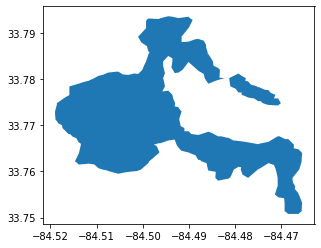

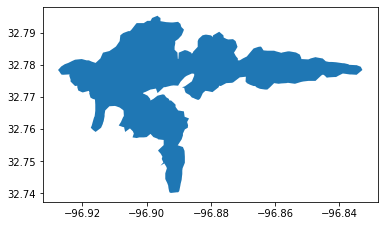

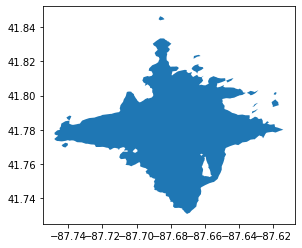

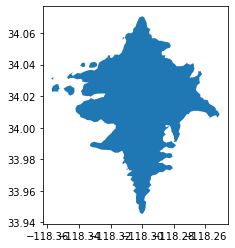

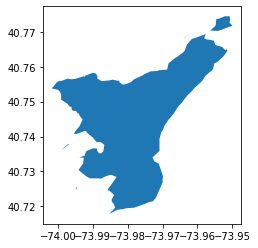

In [3]:
import importlib as imp
from matplotlib import pyplot as plt
imp.reload(isc)

locations = [
    ('atlanta', 33.781961, -84.496635),
    ('dallas', 32.781961, -96.896635),
    ('chicago', 41.78, -87.679),
    ("los_angeles", 34.023, -118.3),
    ("new_york", 40.7411909,-73.9710549)
]


with engine.connect() as conn:
    service = isc.IsochroneService(otp_port=opt_params['port'], pg_conn=conn, reference_date = opt_params['ref_date'])
    for city, lat, long in locations:
        isochrone, real = service.compute_isochrone(lat=lat, lon=long, city=city)   #<- another end point that uses lat/long directly
        print(real)
        gpd.GeoSeries(isochrone).plot()        
    #isochrone, origin_id, catchment_id = service.get_isochrone(city_id = 1, h3_id= '8944c1a8133ffff')

In [13]:
view_state = pydeck.ViewState(
    **{"latitude": 33.7, "longitude": -84.3, "zoom": 10, "maxZoom": 16, "pitch": 0, "bearing": 0}
)

polygon_layer = pydeck.Layer(
    "PolygonLayer",
    data=gpd.GeoDataFrame(geometry=[isochrone]).explode(index_parts=True),
    id="geojson",
    opacity=0.2,
    stroked=True,
    get_polygon="geometry.coordinates",
    filled=True,    
    wireframe=True,    
    get_fill_color=[255, 100, 100],
    get_line_color=[0, 0, 0],
    auto_highlight=True,
    pickable=True,
)

r = pydeck.Deck(
    polygon_layer,
    initial_view_state=view_state,    
    map_style=pydeck.map_styles.LIGHT,
)
r.to_html()

## Iterate through all POIs that do not yet have isochrones


In [4]:
import importlib as imp
imp.reload(isc)

import itertools as itt
from tqdm import tqdm

types = ['morning', 'afternoon', 'evening']
timedistances = [30]
cities = ['Atlanta', 'Dallas', 'Los Angeles', 'New York', 'Chicago']

with engine.connect() as conn:
    service = isc.IsochroneService(otp_port=opt_params['port'], pg_conn=conn, reference_date = opt_params['ref_date'])

    for timedist, timeofday, city in tqdm(list(itt.product(timedistances, types, cities))):
        with conn.connection.cursor() as cur:
            cur.execute("""
                SELECT DISTINCT pois.h3id, cities.cityid FROM cities 
                    JOIN cityh3map ON cityh3map.cityid = cities.cityid 
                    JOIN pois ON pois.h3id = cityh3map.h3id
                    LEFT JOIN catchments ON catchments.originh3id = pois.h3id AND catchments.timedistance = %s AND catchments.timeofday = %s
                    WHERE 
                        catchments.geometry IS NULL AND
                        cities.cityname = %s
                """,
                (timedist, timeofday, city)
            )
            res = cur.fetchall()

            for pid, cityid in tqdm(res):                
                service.get_isochrone(city_id = cityid, h3_id= pid, time = timeofday, minutes=timedist)                
                

0it [00:00, ?it/s]/15 [00:00<?, ?it/s]
100%|██████████| 2012/2012 [00:00<00:00, 2536501.25it/s]
0it [00:00, ?it/s]/15 [00:00<00:01,  7.09it/s]
100%|██████████| 2012/2012 [00:00<00:00, 5985063.58it/s]
0it [00:00, ?it/s]0/15 [00:01<00:00,  7.40it/s]
100%|██████████| 15/15 [00:02<00:00,  7.27it/s]
